# Inference

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scgpt 
from scgpt.preprocess import Preprocessor
from scgpt.model import TransformerModel
from scgpt.tokenizer.gene_tokenizer import GeneVocab
import torch
import json

from scgpt.tokenizer import tokenize_and_pad_batch
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import scvi

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## Step 1: Data loading and preprocessing

In [2]:
czi_reference = sc.read_h5ad("../data/datasets/czi_covid_pbmc_5pct.h5ad") # Obtain reference CZI data for classification labels
id2type = dict(enumerate(czi_reference.obs["cell_type"].astype("category").cat.categories)) # create dict to match labels

In [3]:
# Load query data for influenza condition
adata_read = sc.read_h5ad("../data/inference/influenzaPBMC.h5ad") # only flu condition data from PBMCs from CZI
adata = adata_read

In [4]:
adata_test = sc.read_h5ad("../data/inference/influenzaPBMC.h5ad")
sc.pp.normalize_total(adata_test, target_sum=1e4)

In [5]:
adata_test.layers["counts"] = adata_test.X.copy()

In [38]:
adata_test.raw = adata_test  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata_test,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="dataset_id",
    subset=True,
)

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [41]:
scvi.model.SCVI.setup_anndata(adata_test, layer="counts", batch_key="dataset_id")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [43]:
model = scvi.model.SCVI(adata_test, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()
SCVI_LATENT_KEY = "X_scVI"
adata_test.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider incr

Epoch 269/269: 100%|██████████| 269/269 [08:01<00:00,  1.81s/it, v_num=1, train_loss_step=504, train_loss_epoch=502]

`Trainer.fit` stopped: `max_epochs=269` reached.


Epoch 269/269: 100%|██████████| 269/269 [08:01<00:00,  1.79s/it, v_num=1, train_loss_step=504, train_loss_epoch=502]


In [49]:
sc.pp.neighbors(adata_test, use_rep="X_scVI")
sc.tl.umap(adata_test)
# Store UMAP coordinates from PCA in a new layer
adata_test.obsm["X_scVI_umap"] = adata_test.obsm["X_umap"]

In [53]:
adata_test

AnnData object with n_obs × n_vars = 29752 × 2000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', '_scvi_batch', '_scvi_labels'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_pca', 'X_umap', 'X_pca_umap',

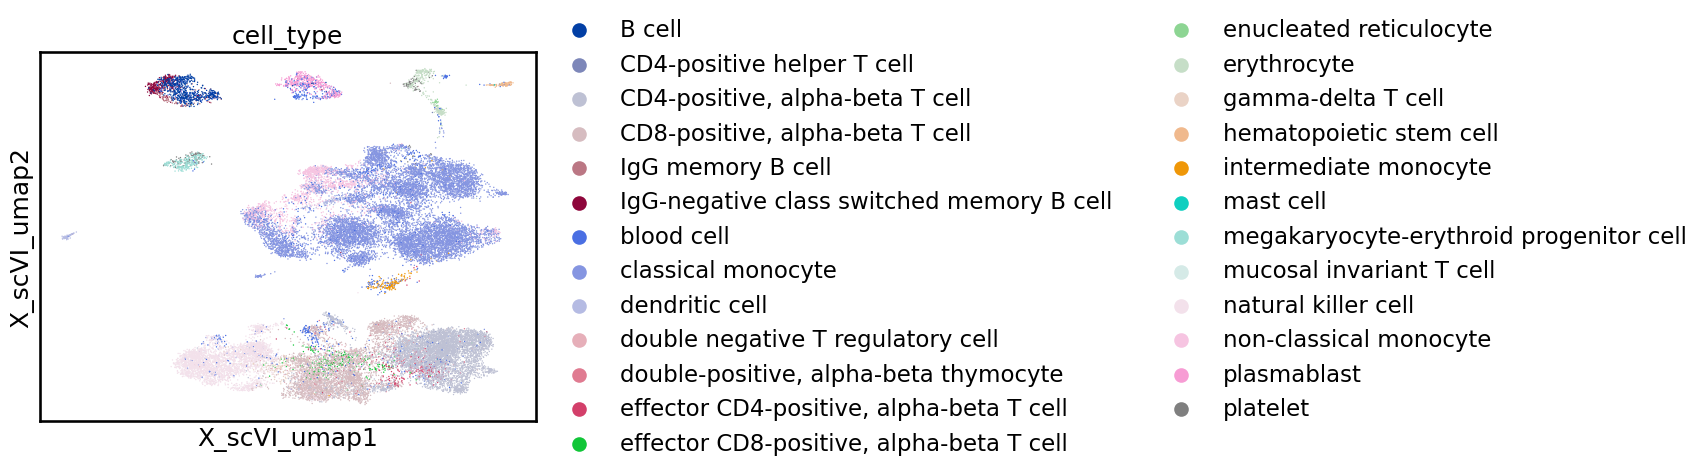

In [57]:
sc.pl.embedding(adata_test, basis="X_scVI_umap",color="cell_type")

In [ ]:
from sklearn.metrics import silhouette_score

sil = silhouette_score(adata_test.obsm["X_pca"], adata_test.obs["cell_type"])
# print(adjusted_rand_score(flu_data.obs["cell_type"], flu_data.obs["leiden_scgpt"]))

print(sil)

-0.028510975


In [45]:
sc.tl.pca(adata_test)

In [6]:
## Remove unused values in columns

obs_cols = list(adata.obs.columns)
print(obs_cols)

for colname in obs_cols:
    if pd.api.types.is_categorical_dtype(adata.obs[colname]): 
        adata.obs[colname] = adata.obs[colname].cat.remove_unused_categories()

['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars']


/tmp/ipykernel_1570110/1256619189.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[colname]):


In [29]:
flu_data_lee = adata[adata.obs.dataset_id=="de2c780c-1747-40bd-9ccf-9588ec186cee"] # Lee et al 2020 influenza study
flu_data_lee.var.index = flu_data_lee.var["feature_name"] # set gene names as features

In [30]:
flu_data_lee

View of AnnData object with n_obs × n_vars = 10519 × 61891
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

In [31]:
# Run scGPT preprocessor
preprocessor = Preprocessor(
    use_key="X",
    normalize_total=1e4, # 1. Normalization protocol - sum to 10000 
    result_normed_key="X_normed",
    log1p=False,  # 2. or True, depending on original training - original training is false
    binning=51,
    subset_hvg=2000,
    hvg_flavor="seurat_v3",
    hvg_use_key="X_normed",
    result_binned_key="X_binned" # 3. Layer for scGPT to work with
)
preprocessor(flu_data_lee)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.


/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


scGPT - INFO - Binning data ...


In [32]:
## Compute PCA -> kNN -> UMAP

# Compute PCA
sc.pp.pca(flu_data_lee)
# Compute neighbors and UMAP using PCA embedding
sc.pp.neighbors(flu_data_lee, use_rep="X_pca")
sc.tl.umap(flu_data_lee)
# Store UMAP coordinates from PCA in a new layer
flu_data_lee.obsm["X_pca_umap"] = flu_data_lee.obsm["X_umap"]

In [33]:
# Load the model config
with open("../models/scgpt_human/args.json") as f:
    args = json.load(f)

# Load vocab
vocab = GeneVocab.from_file("save/finetuning_czi_5pct_2pct/vocab.json")
vocab.set_default_index(vocab["<pad>"])

# Number of cell types in NEW dataset (not original training set)
num_cell_types = 97  # update this

# Initialize model
model = TransformerModel(
    ntoken=len(vocab),
    d_model=args["embsize"],
    nhead=args["nheads"],
    d_hid=args["d_hid"],
    nlayers=args["nlayers"],
    nlayers_cls=args.get("n_layers_cls", 3),
    n_cls=num_cell_types,
    vocab=vocab,
    dropout=args.get("dropout", 0.2),
    pad_token="<pad>",
    pad_value=-2,
    input_emb_style="continuous",
    n_input_bins=args.get("n_input_bins", 51),
    cell_emb_style="cls",
    use_fast_transformer=args.get("fast_transformer", False),
    fast_transformer_backend=args.get("fast_transformer_backend", "flash"),
    pre_norm=args.get("pre_norm", False),
)

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


In [34]:
state_dict = torch.load("save/finetuning_czi_5pct_2pct/best_model.pt", map_location="cpu")

if all(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

In [35]:
model.load_state_dict(state_dict)
model.eval()

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [36]:
gene_ids = np.array([vocab[gene] for gene in flu_data_lee.var_names], dtype=int)

counts = flu_data_lee.layers["X_binned"]  # must match input_layer_key from training

tokenized = tokenize_and_pad_batch(
    counts,
    gene_ids,
    max_len=3001,
    vocab=vocab,
    pad_token="<pad>",
    pad_value=-2,
    append_cls=True,
    include_zero_gene=False
)

In [37]:
# Define inference dataset
class InferenceDataset(Dataset):
    def __init__(self, tokenized):
        self.data = tokenized

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

    def __len__(self):
        return self.data["genes"].shape[0]

# Create dataset and loader
dataset = InferenceDataset(tokenized)
loader = DataLoader(
    dataset, 
    batch_size=12,     # You can experiment with 512, 1024, or 2048 on A30s
    num_workers=8,      # Reduce for GPU-bound tasks
    pin_memory=True,    # Enable for GPU
    shuffle=False
)

# Move model to GPU and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [38]:
all_preds = []
all_embeddings = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch["genes"].to(device, non_blocking=True) # add to device
        values = batch["values"].to(device, non_blocking=True) # add to device
        mask = input_ids.eq(vocab["<pad>"])

        # ---------- Step 1: Full prediction (from classification head) ----------
        out = model(input_ids, values, src_key_padding_mask=mask, CLS=True)
        logits = out["cls_output"]  # Already passed through cls_decoder
        preds = logits.argmax(1)
        all_preds.extend(preds.cpu().numpy())

        # ---------- Step 2: Encoder-only embedding ----------
        # 2.1 Embed genes
        gene_embed = model.encoder.embedding(input_ids)  # [B, L, D]
        gene_embed = model.encoder.enc_norm(gene_embed)

        # 2.2 Embed values
        value_embed = model.value_encoder(values)  # [B, L, D]

        # 2.3 Add them together
        x = gene_embed + value_embed

        # 2.4 Pass through TransformerEncoder
        x = model.transformer_encoder(x, src_key_padding_mask=mask)  # [B, L, D]

        # 2.5 Get CLS token (assumes CLS is first token)
        cls_embed = x[:, 0, :]  # [B, D]
        all_embeddings.append(cls_embed.cpu())

In [39]:
# Save predictions
flu_data_lee.obs["predictions"] = pd.Categorical(all_preds)

# Save encoder embeddings
flu_data_lee.obsm["X_scgpt"] = torch.cat(all_embeddings, dim=0).numpy()

In [40]:
flu_data_lee

AnnData object with n_obs × n_vars = 10519 × 2000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'predictions'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'bin_edges', 'X_pca', 'X_umap', 'X_pca_umap', 'X_scgpt'
    varm: 'PCs'
    layers: 'X_normed', 'X_binned'
    obsp: 'dist

In [41]:
## UMAP from X_scgpt
sc.pp.neighbors(flu_data_lee, use_rep="X_scgpt")
sc.tl.umap(flu_data_lee)
flu_data_lee.obsm["X_umap_scgpt"] = flu_data_lee.obsm["X_umap"]  # copy before it gets overwritten

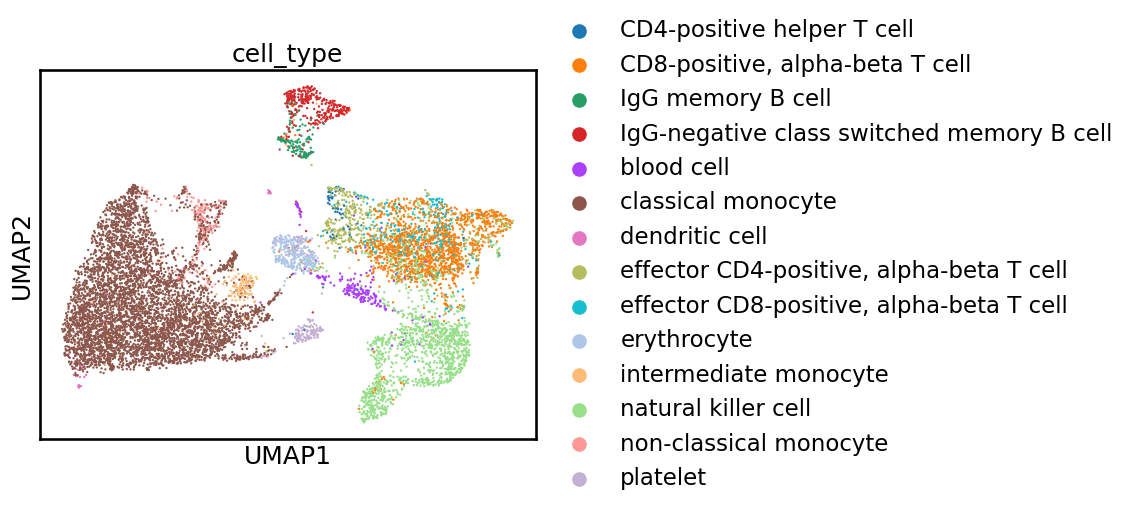

In [45]:
sc.pl.umap(flu_data_lee, color="cell_type")

In [ ]:
flu_data_lee.write_h5ad("flu_scgpt_pca_umaps.h5ad")

In [48]:
# Ensure predictions are integers (in case they're categorical)
pred_ids = flu_data_lee.obs["predictions"].astype(int)

# Map to cell type names using id2type
flu_data_lee.obs["predicted_celltype"] = pred_ids.map(id2type)

flu_data_lee.obs.predicted_celltype.unique()

array(['effector memory CD8-positive, alpha-beta T cell',
       'CD14-positive monocyte', 'classical monocyte',
       'natural killer cell', 'CD8-positive, alpha-beta T cell',
       'monocyte', 'CD14-low, CD16-positive monocyte', 'platelet',
       'effector CD8-positive, alpha-beta T cell', 'naive B cell',
       'erythrocyte', 'myeloid cell',
       'plasmacytoid dendritic cell, human', 'neutrophil',
       'CD8-positive, alpha-beta memory T cell', 'lymphocyte',
       'conventional dendritic cell', 'T-helper 22 cell',
       'central memory CD4-positive, alpha-beta T cell',
       'hematopoietic stem cell',
       'CD16-positive, CD56-dim natural killer cell, human',
       'non-classical monocyte', 'transitional stage B cell', 'T cell',
       'gamma-delta T cell', 'mucosal invariant T cell',
       'naive thymus-derived CD8-positive, alpha-beta T cell',
       'T follicular helper cell', 'memory B cell',
       'CD4-positive, alpha-beta cytotoxic T cell',
       'CD16-negative,

In [49]:
flu_data_lee.obs.predicted_celltype.unique()

array(['effector memory CD8-positive, alpha-beta T cell',
       'CD14-positive monocyte', 'classical monocyte',
       'natural killer cell', 'CD8-positive, alpha-beta T cell',
       'monocyte', 'CD14-low, CD16-positive monocyte', 'platelet',
       'effector CD8-positive, alpha-beta T cell', 'naive B cell',
       'erythrocyte', 'myeloid cell',
       'plasmacytoid dendritic cell, human', 'neutrophil',
       'CD8-positive, alpha-beta memory T cell', 'lymphocyte',
       'conventional dendritic cell', 'T-helper 22 cell',
       'central memory CD4-positive, alpha-beta T cell',
       'hematopoietic stem cell',
       'CD16-positive, CD56-dim natural killer cell, human',
       'non-classical monocyte', 'transitional stage B cell', 'T cell',
       'gamma-delta T cell', 'mucosal invariant T cell',
       'naive thymus-derived CD8-positive, alpha-beta T cell',
       'T follicular helper cell', 'memory B cell',
       'CD4-positive, alpha-beta cytotoxic T cell',
       'CD16-negative,

In [51]:
flu_data_lee.write_h5ad("../data/inference/influenza_lee_czi_preds_hvg.h5ad")

In [44]:
d2 = sc.read_h5ad("../data/inference/influenza_lee_czi_preds.h5ad")
d2

AnnData object with n_obs × n_vars = 10519 × 61891
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'predictions', 'predicted_celltype'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'predicted_celltype_colors', 'predictions_colors', 'umap'
    obsm: 'X_pca', 'X_scgpt', 'X_umap', 'X_umap_pca', 'X_umap_scgpt', 'bin_edges'
    varm: 'PCs'
    layers: 'X_binned', 'X_nor

In [ ]:
# cell_type_key = "cell_type"
# gene_col = "index"

# flu_data_lee_scgpt = scgpt.tasks.embed_data(
#     flu_data_lee,
#     "save/finetuning_czi_5pct_2pct/",
#     gene_col=gene_col,
#     obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
#     batch_size=64,
#     return_new_adata=True,
# )

# # sc.pp.neighbors(adata, use_rep="X_scGPT")
# # sc.tl.umap(adata)
# # sc.pl.umap(adata, color=cell_type_key, frameon=False)

scGPT - INFO - match 40568/61891 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 165/165 [00:59<00:00,  2.78it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
# Ensure predictions and original cell types are in the same DataFrame
comparison_df = adata.obs[["cell_type", "predicted_celltype"]]

# Display the comparison
# print(comparison_df)

# Optionally, group by cell types to see counts for each prediction
grouped_counts = adata.obs.groupby(["cell_type", "predicted_celltype"]).size().reset_index(name="count")
sorted_counts = grouped_counts.sort_values(by="count", ascending=False)

print(sorted_counts)

In [ ]:
# Group by 'celltype' and 'predicted_celltype' and count occurrences
grouped_counts = adata.obs.groupby(["cell_type", "predicted_celltype"]).size().reset_index(name="count")

# Calculate percentages for each 'celltype'
grouped_counts["percentage"] = grouped_counts.groupby("cell_type")["count"].transform(lambda x: (x / x.sum()) * 100)

# Filter out rows where percentage is 0
filtered_counts = grouped_counts[grouped_counts["percentage"] > 0]

# Sort by 'celltype' and 'percentage' in descending order
sorted_counts = filtered_counts.sort_values(by=["cell_type", "percentage"], ascending=[True, False])

# Print the results
for celltype, group in sorted_counts.groupby("cell_type"):
    print(f"Cell Type: {celltype}")
    print(group[["predicted_celltype", "count", "percentage"]])
    print("-" * 50)

In [ ]:
adata.write_h5ad("../data/inference/mukundPBMCPredictions.h5ad")

## Visualization

In [2]:
adata_preds = sc.read_h5ad("../data/inference/influenza_lee_czi_preds.h5ad")

In [3]:
adata_preds

AnnData object with n_obs × n_vars = 10519 × 61891
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'predictions', 'predicted_celltype'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'predicted_celltype_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'bin_edges'
    varm: 'PCs'
    layers: 'X_binned', 'X_normed'
    obsp: 'connectivities', 'distances'

In [5]:
unique_predicted = adata_preds.obs["predicted_celltype"].unique()
print("Unique predicted cell types:", unique_predicted)

Unique predicted cell types: ['effector memory CD8-positive, alpha-beta T cell', 'classical monocyte', 'natural killer cell', 'CD4-positive, alpha-beta cytotoxic T cell', 'non-classical monocyte', ..., 'megakaryocyte-erythroid progenitor cell', 'IgA plasmablast', 'CD4-positive, alpha-beta T cell', 'CD14-low, CD16-positive monocyte', 'blood cell']
Length: 48
Categories (48, object): ['B cell', 'CD4-positive helper T cell', 'CD4-positive, alpha-beta T cell', 'CD4-positive, alpha-beta cytotoxic T cell', ..., 'plasmacytoid dendritic cell, human', 'platelet', 'regulatory T cell', 'transitional stage B cell']


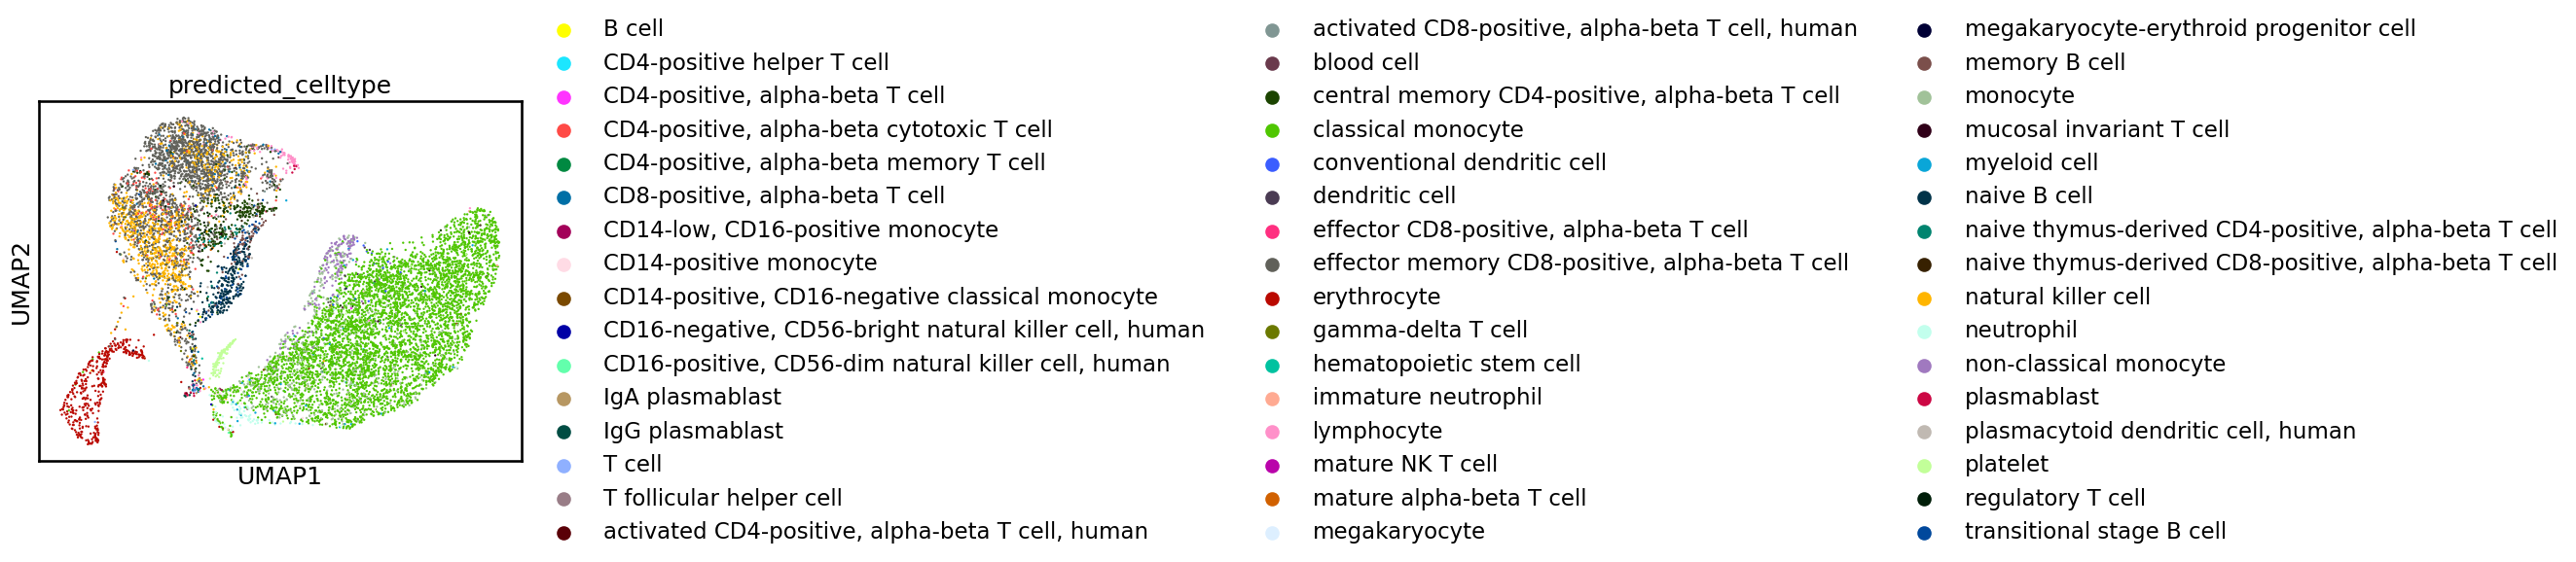

In [4]:
sc.pl.umap(adata_preds, color="predicted_celltype")

In [ ]:
sc.pl.umap(adata_preds, color="celltype")

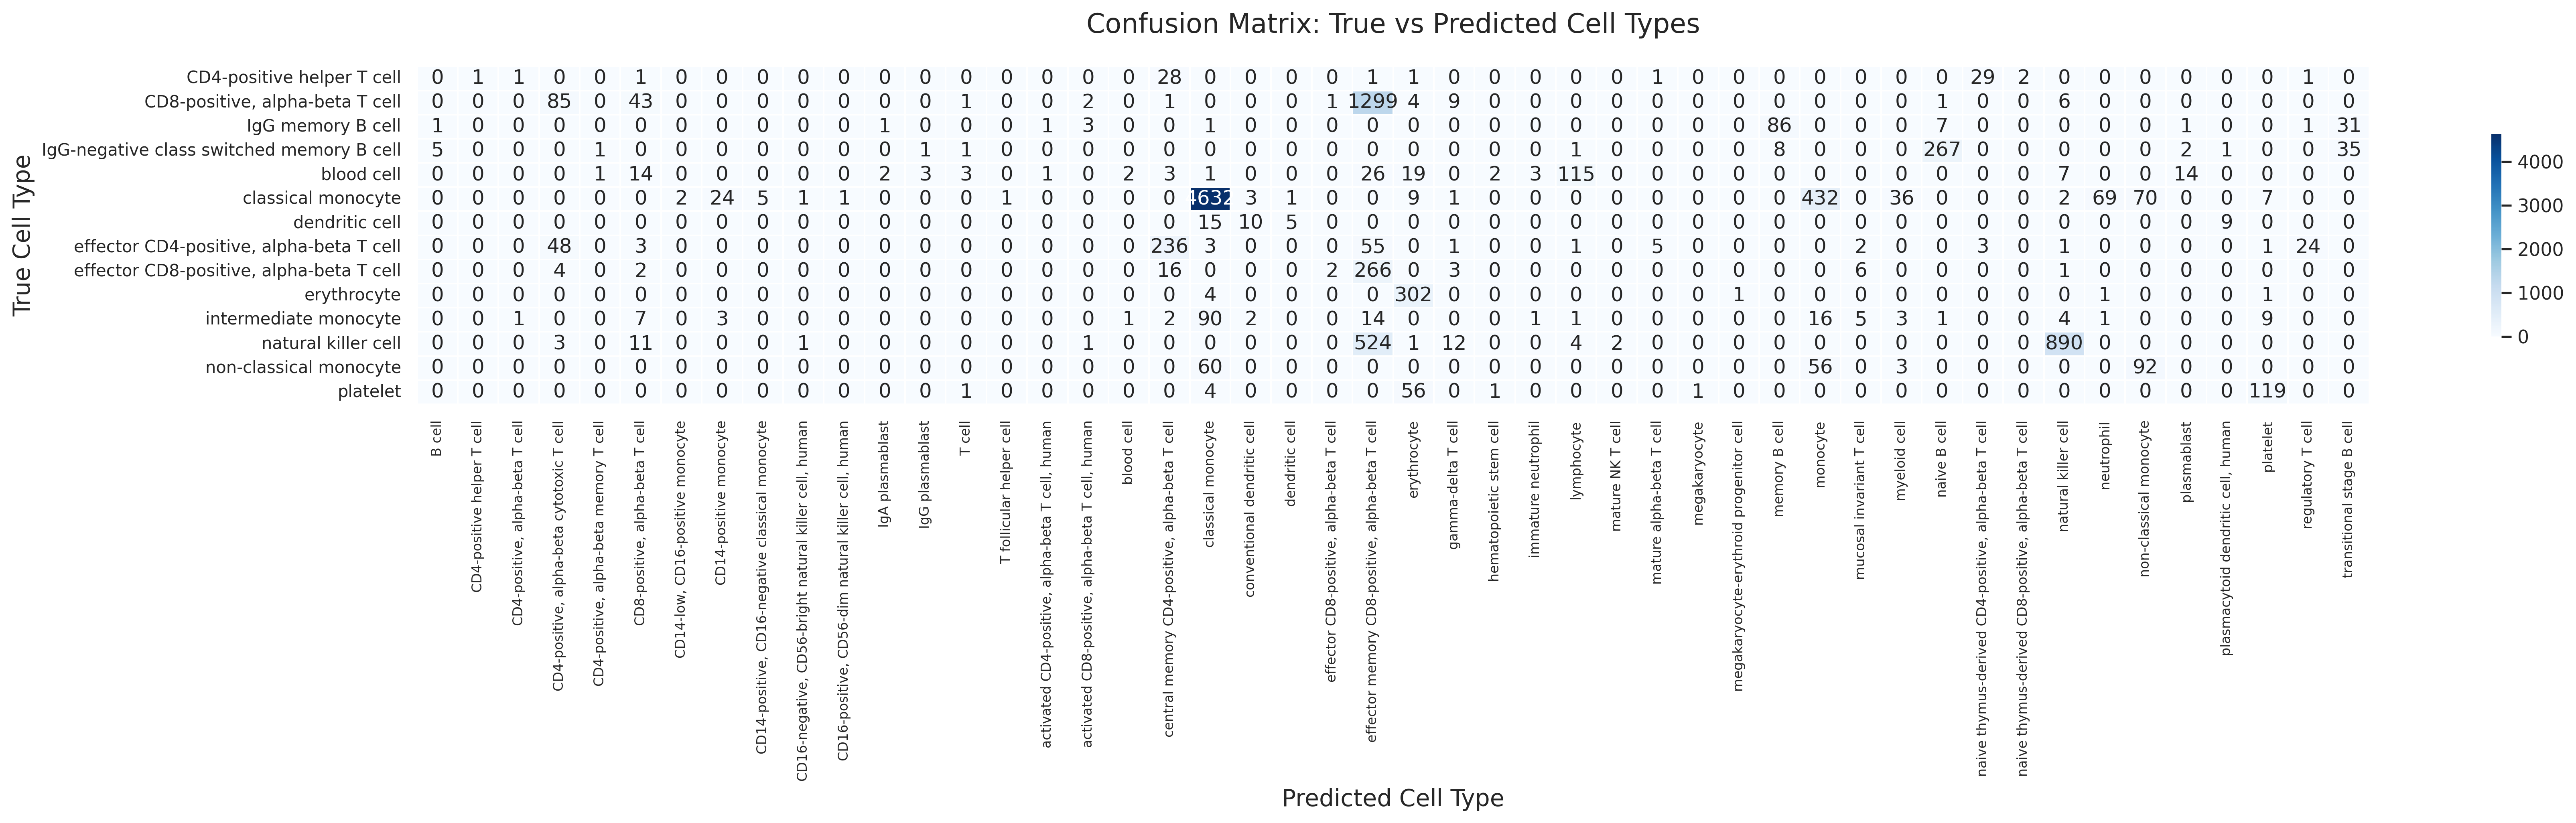

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute confusion matrix
cm = pd.crosstab(
    adata_preds.obs["cell_type"],
    adata_preds.obs["predicted_celltype"],
    rownames=["True Cell Type"],
    colnames=["Predicted Cell Type"],
    dropna=False
)

# Plot confusion matrix
plt.figure(figsize=(24, 7), dpi=300)  # Wider aspect ratio for many predicted types
sns.set(style="white")  # White background

ax = sns.heatmap(
    cm,
    cmap="Blues",
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.6}
)

# Styling
ax.set_title("Confusion Matrix: True vs Predicted Cell Types - Influenza", fontsize=16, pad=20)
ax.set_xlabel("Predicted Cell Type", fontsize=14)
ax.set_ylabel("True Cell Type", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center", fontsize=10)

plt.tight_layout()
plt.show()

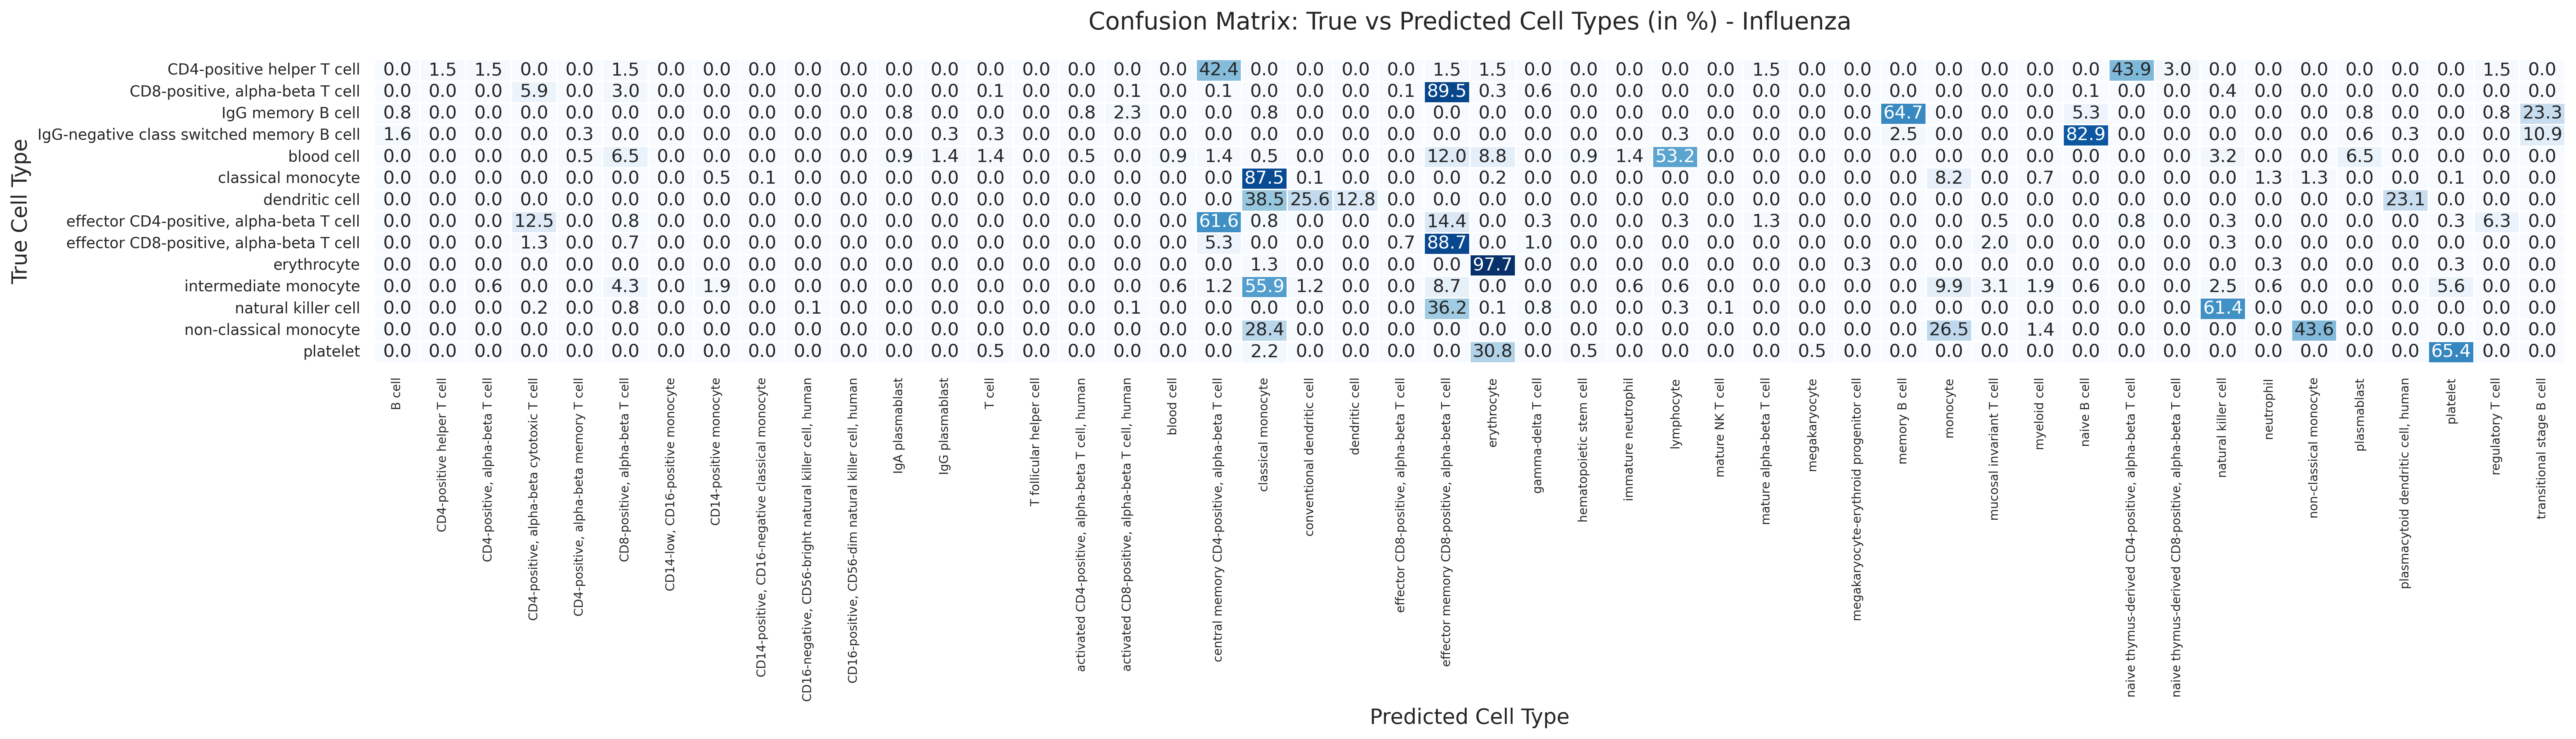

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute raw confusion matrix
cm = pd.crosstab(
    adata_preds.obs["cell_type"],
    adata_preds.obs["predicted_celltype"],
    rownames=["True Cell Type"],
    colnames=["Predicted Cell Type"],
    dropna=False
)

# Normalize row-wise to get percentages
cm_percent = cm.div(cm.sum(axis=1), axis=0) * 100

# Plot confusion matrix
plt.figure(figsize=(24, 7), dpi=300)
sns.set(style="white")

ax = sns.heatmap(
    cm_percent,
    cmap="Blues",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    linecolor="white",
    cbar=False  # Remove colorbar
)

# Styling
ax.set_title("Confusion Matrix: True vs Predicted Cell Types (in %) - Influenza", fontsize=16, pad=20)
ax.set_xlabel("Predicted Cell Type", fontsize=14)
ax.set_ylabel("True Cell Type", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
adata_preds_mukund = sc.read_h5ad("../data/inference/mukundPBMCPredictions.h5ad")

In [13]:
adata_preds_mukund

AnnData object with n_obs × n_vars = 30000 × 14063
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Infection_status', 'Severity', 'log10GenesPerUMI', 'percent.mt', 'percent.Heme', 'Study', 'seurat_clusters', 'new.annot2', 'celltype', 'celltype_id', 'batch_id', 'predictions', 'predicted_celltype'
    var: 'gene_name'
    obsm: 'bin_edges'
    layers: 'X_binned', 'X_normed'

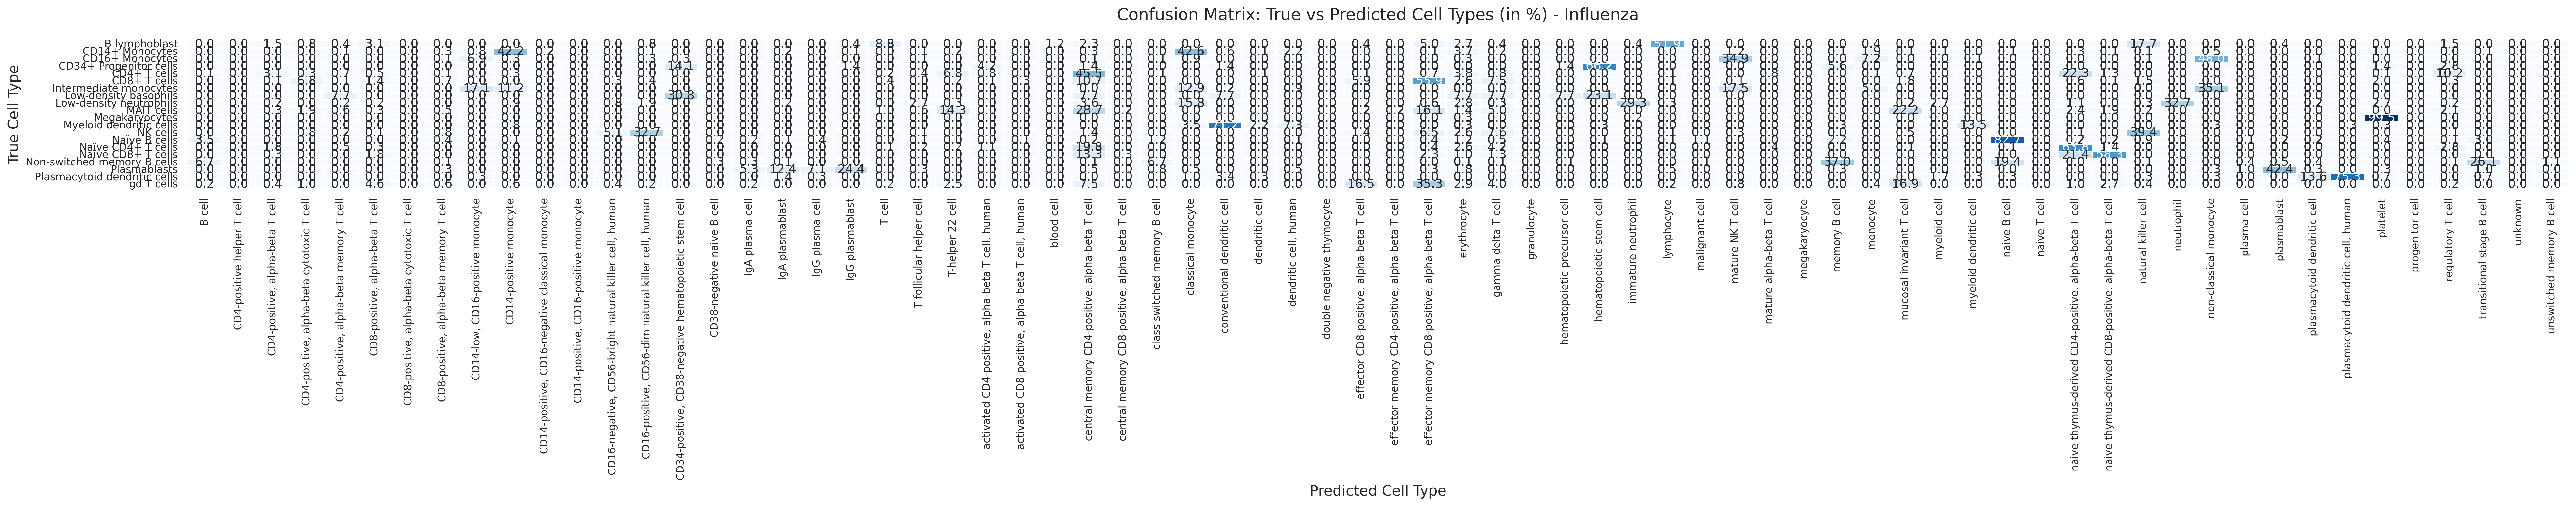

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute raw confusion matrix
cm_covid = pd.crosstab(
    adata_preds_mukund.obs["celltype"],
    adata_preds_mukund.obs["predicted_celltype"],
    rownames=["True Cell Type"],
    colnames=["Predicted Cell Type"],
    dropna=False
)

# Normalize row-wise to get percentages
cm_percent_covid = cm_covid.div(cm_covid.sum(axis=1), axis=0) * 100

# Plot confusion matrix
plt.figure(figsize=(35, 7), dpi=300)
sns.set(style="white")

ax = sns.heatmap(
    cm_percent_covid,
    cmap="Blues",
    annot=True,
    fmt=".1f",
    linewidths=1,
    linecolor="white",
    cbar=False  # Remove colorbar
)

# Styling
ax.set_title("Confusion Matrix: True vs Predicted Cell Types (in %) - Influenza", fontsize=16, pad=20)
ax.set_xlabel("Predicted Cell Type", fontsize=14)
ax.set_ylabel("True Cell Type", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [28]:
top3_predictions = {}

pd.set_option('display.max_colwidth', None)

for true_type in cm_percent.index:
    top_preds = cm_percent.loc[true_type].sort_values(ascending=False).head(3)
    top3_predictions[true_type] = [
        f"{pred} ({top_preds[pred]:.1f}%)" for pred in top_preds.index
    ]

# Convert to DataFrame
top3_df = pd.DataFrame.from_dict(
    top3_predictions, orient='index',
    columns=['Top Prediction', 'Top #2', 'Top #3']
)

# Display
top3_df

Top Prediction  \
CD4-positive helper T cell                 naive thymus-derived CD4-positive, alpha-beta T cell (43.9%)   
CD8-positive, alpha-beta T cell                 effector memory CD8-positive, alpha-beta T cell (89.5%)   
IgG memory B cell                                                                 memory B cell (64.7%)   
IgG-negative class switched memory B cell                                          naive B cell (82.9%)   
blood cell                                                                           lymphocyte (53.2%)   
classical monocyte                                                           classical monocyte (87.5%)   
dendritic cell                                                               classical monocyte (38.5%)   
effector CD4-positive, alpha-beta T cell         central memory CD4-positive, alpha-beta T cell (61.6%)   
effector CD8-positive, alpha-beta T cell        effector memory CD8-positive, alpha-beta T cell (88.7%)   
erythrocyte                                                                         erythrocyte (97.7%)   
intermediate monocyte                                                        classical monocyte (55.9%)   
natural killer cell                                                         natural killer cell (61.4%)   
non-classical monocyte                                                   non-classical monocyte (43.6%)   
platelet                                                                               platelet (65.4%)   

                                                                                            Top #2  \
CD4-positive helper T cell                  central memory CD4-positive, alpha-beta T cell (42.4%)   
CD8-positive, alpha-beta T cell                   CD4-positive, alpha-beta cytotoxic T cell (5.9%)   
IgG memory B cell                                                transitional stage B cell (23.3%)   
IgG-negative class switched memory B cell                        transitional stage B cell (10.9%)   
blood cell                                 effector memory CD8-positive, alpha-beta T cell (12.0%)   
classical monocyte                                                                 monocyte (8.2%)   
dendritic cell                                                 conventional dendritic cell (25.6%)   
effector CD4-positive, alpha-beta T cell   effector memory CD8-positive, alpha-beta T cell (14.4%)   
effector CD8-positive, alpha-beta T cell     central memory CD4-positive, alpha-beta T cell (5.3%)   
erythrocyte                                                              classical monocyte (1.3%)   
intermediate monocyte                                                              monocyte (9.9%)   
natural killer cell                        effector memory CD8-positive, alpha-beta T cell (36.2%)   
non-classical monocyte                                                  classical monocyte (28.4%)   
platelet                                                                       erythrocyte (30.8%)   

                                                                                                Top #3  
CD4-positive helper T cell                 naive thymus-derived CD8-positive, alpha-beta T cell (3.0%)  
CD8-positive, alpha-beta T cell                                 CD8-positive, alpha-beta T cell (3.0%)  
IgG memory B cell                                                                  naive B cell (5.3%)  
IgG-negative class switched memory B cell                                         memory B cell (2.5%)  
blood cell                                                                          erythrocyte (8.8%)  
classical monocyte                                                       non-classical monocyte (1.3%)  
dendritic cell                                              plasmacytoid dendritic cell, human (23.1%)  
effector CD4-positive, alpha-beta T cell             CD4-positive, alpha-beta cytotoxic T cell (12.5%)  
effecto